## Project 4 - Anomaly Detection

Team members: Vamshi Gujjari, Hemant Koti

[Dataset](https://raw.githubusercontent.com/numenta/NAB/master/data/realTraffic/TravelTime_451.csv)

Model Links <br>
[Autoencoder with Conv1d layers](https://drive.google.com/file/d/1wRjpZVdYznhjc7YawALmA3OR-HNlmaI2/view?usp=sharing) <br>
[Autoencoder with LSTM layers](https://drive.google.com/file/d/1UG9EyHNXsnmR2rZEQ6r05MNFv64Q-hm9/view?usp=sharing) <br>
[Autoencoder with Dense layers](https://drive.google.com/file/d/1mPVf7oM0vjC2R8EIuEZIR1Q5PyKelD7m/view?usp=sharing) <br>

In this notebook, we'll apply deep learning techniques for anomaly detection using Dense neural networks and autoencoders. <br>  

The dataset used is a real-time traffic data from the Twin Cities Metro area in Minnesota, collected by the Minnesota Department of Transportation. The dataset includes metrics such as occupancy, speed, and travel time from different sensors. <br>

In part 1 of the notebook, we will use a dense neural network for predicting future sequences in the series. <br>

In part 2 of the notebook, we will build a simple autoencoder with LSTM, Dense, and Conv1d layers and compare results between vanilla models and autoencoders.

### Part I: MLP for Anomaly Detection

In [164]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [165]:
from tensorflow import keras
from tensorflow.keras import layers

from keras import backend as K
from keras.models import Model
from keras.layers import Activation, BatchNormalization
from keras.layers import Dropout, Dense, Input, LSTM
from keras.optimizers import Adam

In [166]:
%matplotlib inline
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#### 1. Choose any dataset from NAB (except those used in class) and prepare it for training (normalize, split between train/ test/ validation). Explore the dataset by visualizing it and showing statistical parameters about it.

In [167]:
data = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realTraffic/TravelTime_451.csv')
data.shape

(2162, 2)

In [168]:
data.head()

,timestamp,value
0,2015-07-28 11:56:00,248
1,2015-07-28 12:06:00,178
2,2015-07-28 12:25:00,155
3,2015-07-28 13:56:00,121
4,2015-07-28 14:06:00,103


In [169]:
data.tail()

,timestamp,value
2157,2015-09-17 16:23:00,255
2158,2015-09-17 16:34:00,189
2159,2015-09-17 16:44:00,193
2160,2015-09-17 17:00:00,216
2161,2015-09-17 17:09:00,209


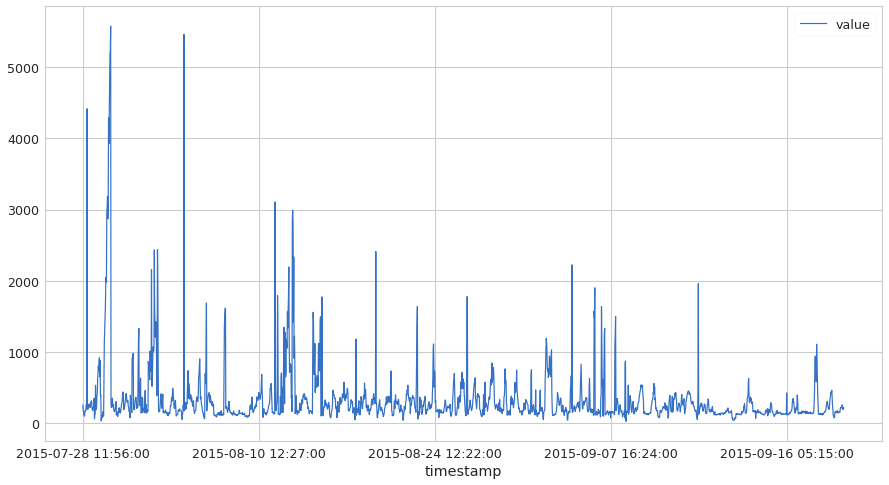

In [171]:
data.set_index('timestamp').plot(figsize=(15, 8))

In [ ]:
# Reference: Code snippet from: https://colab.research.google.com/github/jdwittenauer/ipython-notebooks/blob/master/notebooks/keras/AnomalyDetection.ipynb
def prepare_data(data, n_timesteps, n_features):

    X = data['value'].values.reshape((len(data), 1))
    y = data['value'].values.reshape((len(data), 1))

    X = X[:-1, :]
    y = y[1:, :]
    
    X_train, X_val, y_train, y_val = X[:int(len(X)*0.8)], X[int(len(X)*0.8):], y[:int(len(y)*0.8)], y[int(len(y)*0.8):]
    n_samples = X_train.shape[0]
    n_val_samples = X_val.shape[0]

    X_train_list = [np.expand_dims(X_train[i-n_timesteps:i, :], axis=0) for i in range(n_timesteps, n_samples + 1)]
    X_train_list = X_train_list[:-(n_features+2)]
    X_train = np.concatenate(X_train_list, axis=0)
    y_train_list = [np.expand_dims(y_train[i+1:i+n_features+1, :], axis=0) for i in range(n_timesteps, n_samples + 1)]
    y_train_list = y_train_list[:-(n_features+2)]
    y_train = np.concatenate(y_train_list, axis=0)
    X_train = X_train[:-1, :, :]
    y_train = y_train[1:, :, :]

    X_val_list = [np.expand_dims(X_val[i-n_timesteps:i, :], axis=0) for i in range(n_timesteps, n_val_samples+1)]
    X_val_list = X_val_list[:-(n_features+2)]
    X_val = np.concatenate(X_val_list, axis=0)
    y_val_list = [np.expand_dims(y_val[i+1:i+n_features+1, :], axis=0) for i in range(n_timesteps, n_val_samples+1)]
    y_val_list = y_val_list[:-(n_features+2)]
    y_val = np.concatenate(y_val_list, axis=0)
    X_val = X_val[:-1, :, :]
    y_val = y_val[1:, :, :]
    return X_train, X_val, y_train, y_val

#### 2. Build an MLP/LSTM model for predicting a sequence of values (min 5 values). Work with 3 different setups of the window size and the size of the output sequence.

In [ ]:
def DenseModel(n_timesteps, n_features):
    i = Input(shape=(n_timesteps,))
    
    x = Dense(200, kernel_initializer='he_normal')(i)
    x = Dropout(0.2)(x)
    
    x = Dense(200, kernel_initializer='he_normal')(x)
    x = Dropout(0.2)(x)

    x = Dense(200, kernel_initializer='he_normal')(x)
    x = Dropout(0.4)(x)

    x = Dense(n_features, kernel_initializer='he_normal')(x)
    x = Activation('linear')(x)

    model = Model(inputs=i, outputs=x)
    opt = Adam(lr=0.01)
    model.compile(loss='mean_absolute_error', optimizer=opt)
    
    return model

#### 3. Using 3 different loss/distance measures identify the anomalies in the dataset. Compare the measurements.

#### 4. Discuss the results and provide the graphs, e.g. train vs validation accuracy and loss over time. 

The function below trains the model with the given train and validation data and plots the training and validation loss, then calls *get_anomalies* method and scatters the anomalies from that funciton over the normal data.

This function identifies if the given point is an anomaly, by comparing it with the given threshold.

In [172]:
def is_anomaly(error, mean, std, threshold):
    delta = np.abs(error - mean)
    multiple = delta / std
    if multiple < threshold:
        return 0
    else:
        return 1

In the function below, the error values are calculated using the given error function in the initial function call. The outputs from this function are the X and y values of the anomaly data, which will be scattered over the normal data plot.

In [ ]:
from statistics import mean, stdev
def get_anomalies(model,X, Y, err, stds):
    y_pred = model.predict(X[:, :, :])
    
    x, y = [], []
    if err == "MAE": #Mean Absolute Error
        errors = [mean_absolute_error(y_train[i, :], y_pred[i, :]) for i in range(y_pred.shape[0])]
        err_mean = mean(errors)
        err_stdev = stdev(errors)

        errors = [mean_absolute_error(Y[i, :], y_pred[i, :]) for i in range(y_pred.shape[0])]
    elif err == "MSE": #Mean Squared Error
        errors = [mean_squared_error(y_train[i, :], y_pred[i, :]) for i in range(y_pred.shape[0])]
        err_mean = mean(errors)
        err_stdev = stdev(errors)

        errors = [mean_squared_error(Y[i, :], y_pred[i, :]) for i in range(y_pred.shape[0])]
    elif err == "RMSE": #Root Mean Squared Error
        errors = [np.sqrt(mean_squared_error(y_train[i, :], y_pred[i, :])) for i in range(y_pred.shape[0])]
        err_mean = mean(errors)
        err_stdev = stdev(errors)

        errors = [np.sqrt(mean_squared_error(Y[i, :], y_pred[i, :])) for i in range(y_pred.shape[0])]
    else:
        print("Wrong Error Function!")

    
    result = [is_anomaly(i, err_mean, err_stdev, stds) for i in errors]
    
    for i in range(len(result)): 
        if result[i] == 1:
            x.append(i)
            y.append(Y[i][0])
    return x,y

Three different setups with different window size and output sequences are used to detect anomalies. Three different loss measures viz., mean absolute error, mean squared error, root mean squared error are taken for each setup. Graphs are plotted for test and validation errors and anomalies are scattered over the data plots. 

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import norm
from itertools import chain

errors = []
def train_and_get_plots(X_train, X_val, y_train, y_val, n_timesteps, n_features, error=1, stds=1):
    model = DenseModel(n_timesteps, n_features)
    model.summary()
    history = model.fit(x=X_train.squeeze(), y=y_train.squeeze(), batch_size=128, epochs=50, verbose=1,
                    callbacks=None, validation_data=(X_val, y_val), shuffle=False)
    
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.legend()
    plt.show()

    y_train_pred = model.predict(X_train)

    train_x, train_y = get_anomalies(model, X_train, y_train, error, stds)
    val_x, val_y = get_anomalies(model, X_val, y_val, error, stds)
    all = y_train[:].squeeze()[:,0].tolist() + y_val[:].squeeze()[:,0].tolist()

    final_x = list(chain(train_x, val_x))
    final_y = list(chain(train_y, val_y))

    plt.figure(figsize=(15,8))
    plt.plot(all)
    plt.scatter(final_x,final_y, color="r")
    plt.show()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 288)]             0         
_________________________________________________________________
dense (Dense)                (None, 200)               57800     
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)              

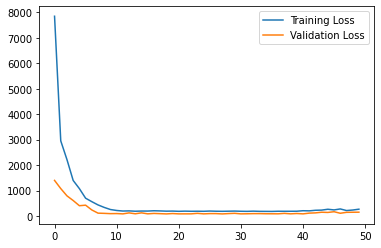

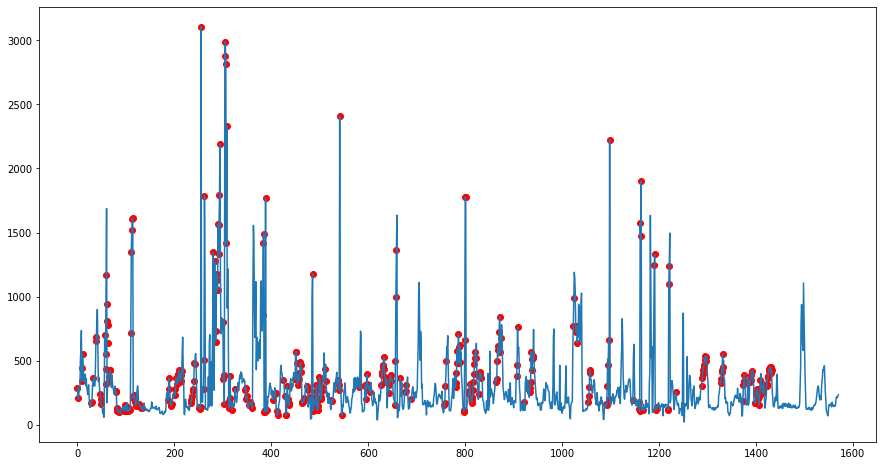

In [ ]:
X_train, X_val, y_train, y_val = prepare_data(data, 288, 5)
train_and_get_plots(X_train, X_val, y_train, y_val, 288, 5, "MAE", 1) #Mean Absolute Error

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 288)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               57800     
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)              

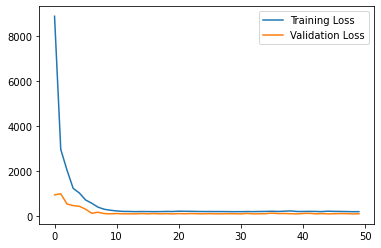

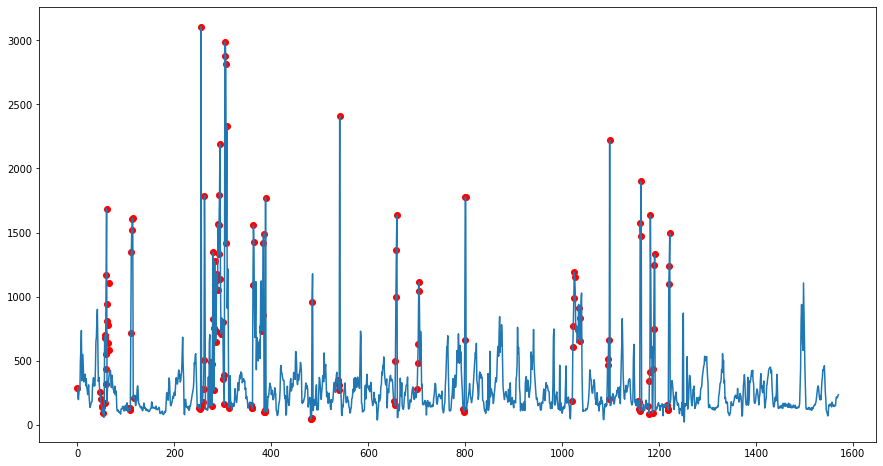

In [ ]:
X_train, X_val, y_train, y_val = prepare_data(data, 288, 5)
train_and_get_plots(X_train, X_val, y_train, y_val, 288, 5, "RMSE", 1) #Root Mean Squared Error

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 288)]             0         
_________________________________________________________________
dense_8 (Dense)              (None, 200)               57800     
_________________________________________________________________
dropout_6 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_8 (Dropout)          (None, 200)              

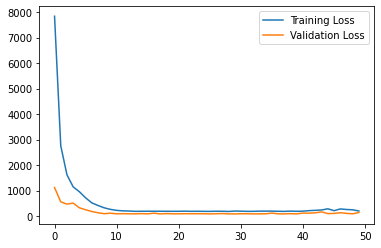

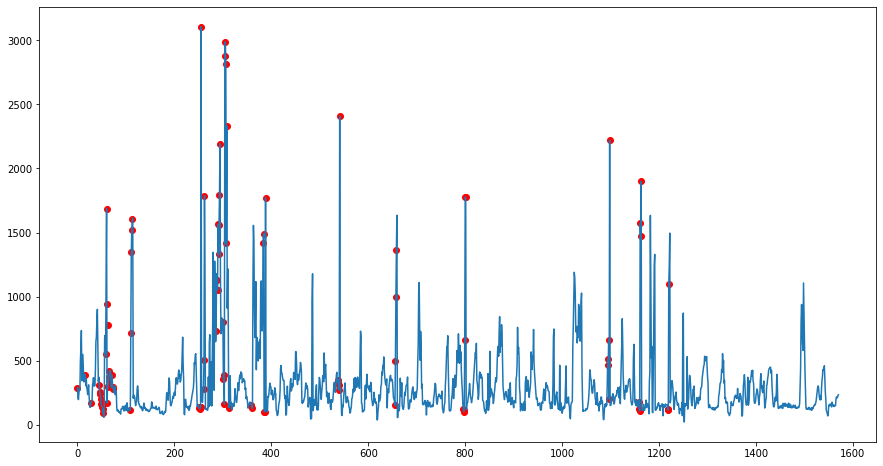

In [ ]:
X_train, X_val, y_train, y_val = prepare_data(data, 288, 5)
train_and_get_plots(X_train, X_val, y_train, y_val, 288, 5, "MSE", 1) #Mean Squared Error

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 72)]              0         
_________________________________________________________________
dense_36 (Dense)             (None, 200)               14600     
_________________________________________________________________
dropout_27 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_28 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_29 (Dropout)         (None, 200)             

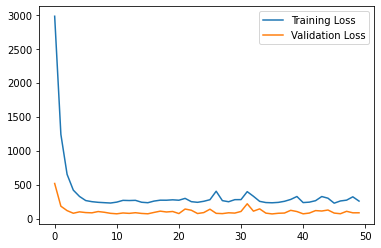

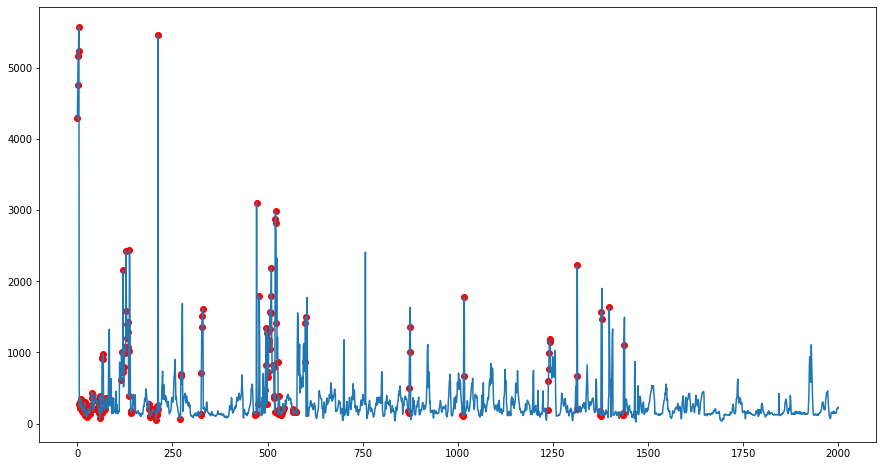

In [ ]:
X_train, X_val, y_train, y_val = prepare_data(data, 72, 6)
train_and_get_plots(X_train, X_val, y_train, y_val, 72, 6, "MAE", 1)

Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 72)]              0         
_________________________________________________________________
dense_40 (Dense)             (None, 200)               14600     
_________________________________________________________________
dropout_30 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_31 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_32 (Dropout)         (None, 200)             

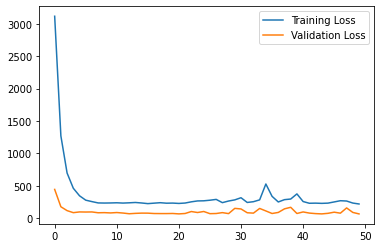

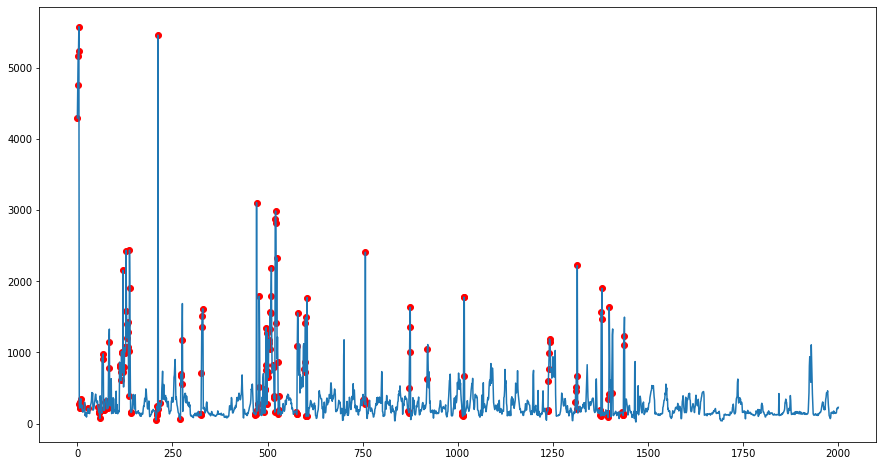

In [ ]:
X_train, X_val, y_train, y_val = prepare_data(data, 72, 6)
train_and_get_plots(X_train, X_val, y_train, y_val, 72, 6, "RMSE", 1)

Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 72)]              0         
_________________________________________________________________
dense_44 (Dense)             (None, 200)               14600     
_________________________________________________________________
dropout_33 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_34 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_35 (Dropout)         (None, 200)             

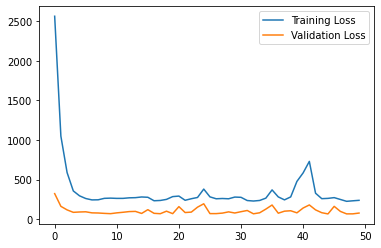

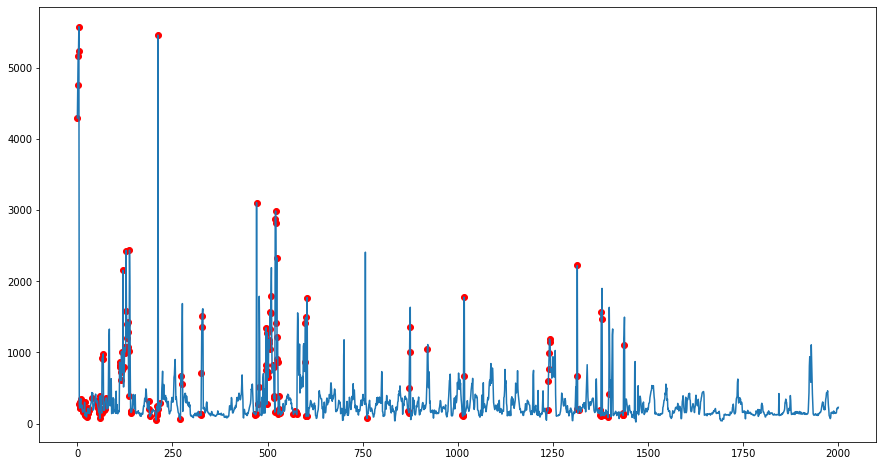

In [ ]:
X_train, X_val, y_train, y_val = prepare_data(data, 72, 6)
train_and_get_plots(X_train, X_val, y_train, y_val, 72, 6, "MAE", 1) #Mean Absolute Error

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 144)]             0         
_________________________________________________________________
dense_24 (Dense)             (None, 200)               29000     
_________________________________________________________________
dropout_18 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_19 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_20 (Dropout)         (None, 200)             

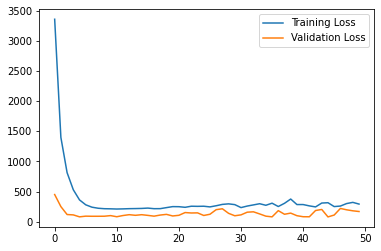

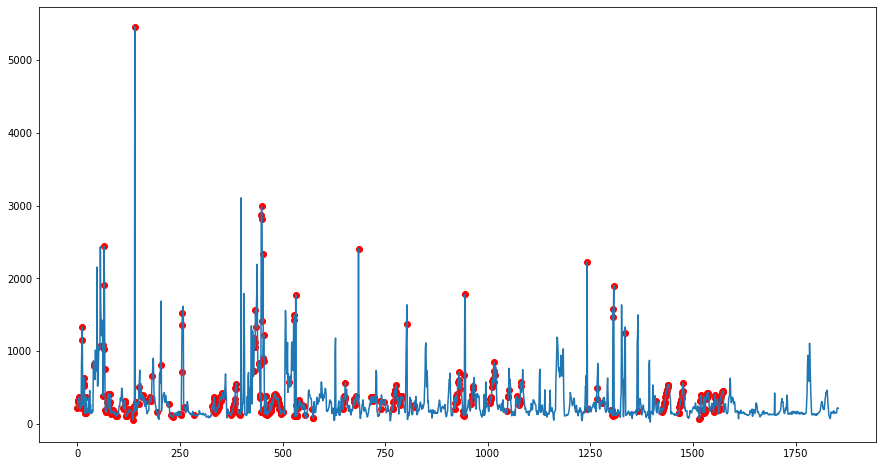

In [ ]:
X_train, X_val, y_train, y_val = prepare_data(data, 144, 7)
train_and_get_plots(X_train, X_val, y_train, y_val, 144, 7, "MAE", 1)

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 144)]             0         
_________________________________________________________________
dense_28 (Dense)             (None, 200)               29000     
_________________________________________________________________
dropout_21 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_22 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_23 (Dropout)         (None, 200)             

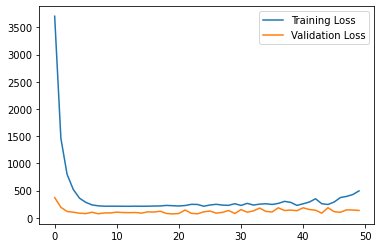

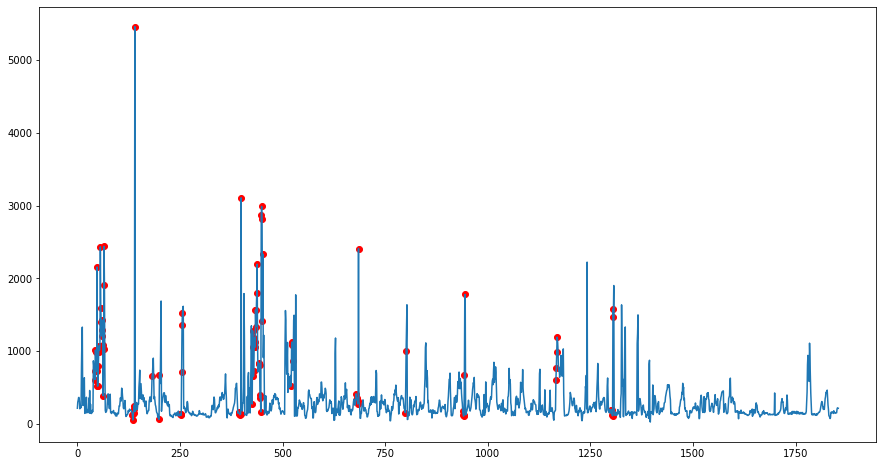

In [ ]:
X_train, X_val, y_train, y_val = prepare_data(data, 144, 7)
train_and_get_plots(X_train, X_val, y_train, y_val, 144, 7, "MSE", 1)

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 144)]             0         
_________________________________________________________________
dense_32 (Dense)             (None, 200)               29000     
_________________________________________________________________
dropout_24 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_25 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_26 (Dropout)         (None, 200)             

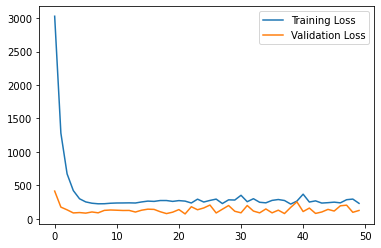

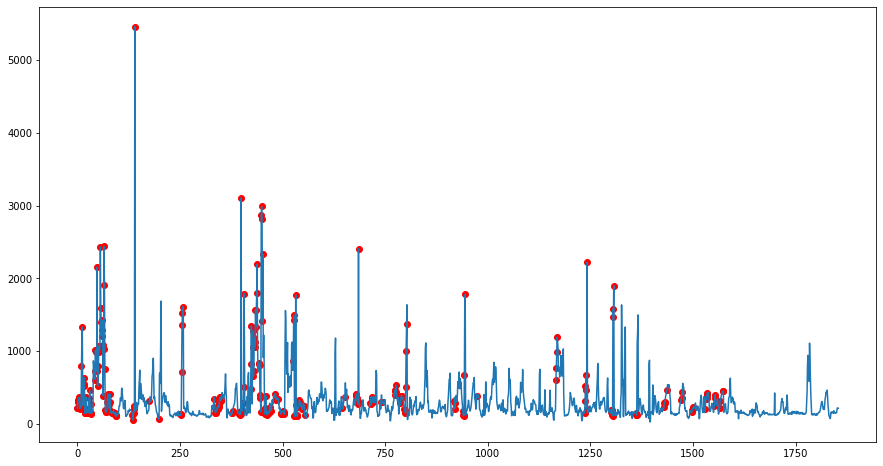

In [ ]:
X_train, X_val, y_train, y_val = prepare_data(data, 144, 7)
train_and_get_plots(X_train, X_val, y_train, y_val, 144, 7, "RMSE", 1)

### Part II: Autoencoder for Anomaly Detection

#### 1. Build a Autoencoder model for predicting a sequence of values. Show 3 different Autoencoder setups (e.g. using Dense/ LSTM/ Conv1D layers).

In [212]:
# Reference: Code snippet from: https://colab.research.google.com/github/jdwittenauer/ipython-notebooks/blob/master/notebooks/keras/AnomalyDetection.ipynb
def prepare_data(data, n_timesteps, n_features):
    X = data['value'].values.reshape((len(data), 1))
    y = data['value'].values.reshape((len(data), 1))

    X = X[:-1, :]
    y = y[1:, :]

    X_train, X_val, y_train, y_val = X[:int(len(X)*0.8)], X[int(len(X)*0.8):], y[:int(len(y)*0.8)], y[int(len(y)*0.8):]
    print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

    n_samples = X_train.shape[0]
    n_val_samples = X_test.shape[0]

    X_train_list = [np.expand_dims(X_train[i-n_timesteps:i, :], axis=0) for i in range(n_timesteps, n_samples + 1)]
    X_train = np.concatenate(X_train_list, axis=0)
    y_train = y_train[n_timesteps-1:, :]

    X_val_list = [np.expand_dims(X_val[i-n_timesteps:i, :], axis=0) for i in range(n_timesteps, n_val_samples + 1)]
    X_val = np.concatenate(X_val_list, axis=0)
    y_val = y_val[n_timesteps-1:, :]

    print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

    return X_train, X_val, y_train, y_val

We have a total of 12 points every day in the dataset, hence we chose the number of timesteps as 12. We will be predicting the value for a single value in the future sequence, hence the number of features will be 1.

In [213]:
n_timesteps = 12
n_features = 1

print('Number of samples: ', n_samples)
print('Number of features: ', n_features)

X_train, X_val, y_train, y_val = prepare_data(data, n_timesteps, n_features)

Number of samples:  1717
Number of features:  1
(1728, 1) (1728, 1) (433, 1) (433, 1)
(1717, 12, 1) (1717, 1) (411, 12, 1) (422, 1)


**Autoencoder with LSTM layers.**

Autoencoder models consist of an "encoder-decoder" pattern which we've implemented using LSTM layers below. The output is a time distributed activation on a dense layer with the size equal to the number of features.

In [214]:
 dimensions = 100
 def AutoencoderLSTM(n_timesteps, n_features):
    i = Input(shape=(n_timesteps, n_features))
    
    x = LSTM(dimensions, activation='relu', return_sequences=True, input_shape=(n_timesteps, n_features))(i)
    x = Dropout(0.2)(x)

    x = LSTM(int(dimensions/2), activation='relu', return_sequences=True)(x)
    x = Dropout(0.2)(x)

    x = LSTM(int(dimensions/2), activation='relu', return_sequences=True)(x)
    x = LSTM(dimensions, activation='relu', return_sequences=True)(x)

    output = layers.TimeDistributed(Dense(n_features))(x)
    model = Model(inputs=i, outputs=output)
    opt = Adam(lr=0.01)
    model.compile(loss='mean_absolute_error', optimizer=opt)
    
    return model

In [215]:
model = AutoencoderLSTM(n_timesteps, n_features)
model.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 12, 1)]           0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 12, 100)           40800     
_________________________________________________________________
dropout_24 (Dropout)         (None, 12, 100)           0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 12, 50)            30200     
_________________________________________________________________
dropout_25 (Dropout)         (None, 12, 50)            0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 12, 50)            20200     
_________________________________________________________________
lstm_19 (LSTM)               (None, 12, 100)         

We initially experimented with 20 epochs but the training loss was too high and did not converge. We increased the number of epochs to 70 which resulted in a better convergence.

In [216]:
history = model.fit(X_train, X_train, batch_size=64, epochs=70, verbose=2, callbacks=None, validation_split=0.1, shuffle=False)

Epoch 1/70
25/25 - 2s - loss: 303.9271 - val_loss: 142.1570
Epoch 2/70
25/25 - 1s - loss: 235.4695 - val_loss: 163.6894
Epoch 3/70
25/25 - 1s - loss: 244.8492 - val_loss: 151.0359
Epoch 4/70
25/25 - 1s - loss: 231.5856 - val_loss: 97.0082
Epoch 5/70
25/25 - 1s - loss: 228.9685 - val_loss: 137.6847
Epoch 6/70
25/25 - 1s - loss: 233.4044 - val_loss: 131.0749
Epoch 7/70
25/25 - 1s - loss: 219.5502 - val_loss: 131.6848
Epoch 8/70
25/25 - 1s - loss: 228.4107 - val_loss: 143.4863
Epoch 9/70
25/25 - 1s - loss: 225.2453 - val_loss: 156.4474
Epoch 10/70
25/25 - 1s - loss: 220.4620 - val_loss: 141.8274
Epoch 11/70
25/25 - 1s - loss: 207.0055 - val_loss: 134.6020
Epoch 12/70
25/25 - 1s - loss: 199.9629 - val_loss: 136.6550
Epoch 13/70
25/25 - 1s - loss: 185.0344 - val_loss: 123.6396
Epoch 14/70
25/25 - 1s - loss: 183.2630 - val_loss: 133.7870
Epoch 15/70
25/25 - 1s - loss: 165.6395 - val_loss: 91.6287
Epoch 16/70
25/25 - 1s - loss: 137.8751 - val_loss: 99.3422
Epoch 17/70
25/25 - 1s - loss: 128.5

In [180]:
model.save('drive/My Drive/Colab Notebooks/autoencoderlstm.h5')

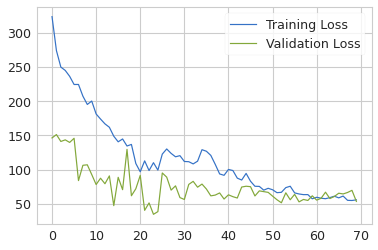

In [181]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

#### 2. For one of the model builded in 1 show the process of hyperparameters tuning (e.g. thresholds, # of layers, activation functions).

Here we generate predictions on the training dataset and calculate the error for all the timestamps.

In [182]:
model = keras.models.load_model('drive/My Drive/Colab Notebooks/autoencoderlstm.h5')

In [183]:
y_train_pred = model.predict(X_train)
type(y_train_pred)

numpy.ndarray

In [184]:
y_train_pred = y_train_pred[:, 0, :]
y_train_pred.shape

(1717, 1)

In [185]:
from sklearn.metrics import mean_absolute_error
errors = [mean_absolute_error(y_train[i, :], y_train_pred[i, :]) for i in range(y_train_pred.shape[0])]
len(errors)

1717

Here we plot the density distribution of errors to get an idea about our training data. This helps in predicting the boundary conditions of our dataset and thereby listing any anomalies. We can see that the errors aren't normally distributed.

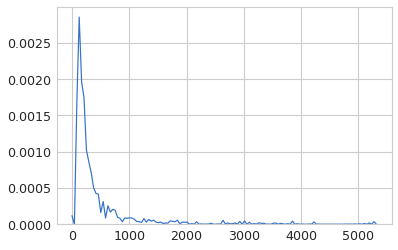

In [211]:
import seaborn as sb
sb.kdeplot(errors, bw=0.2)

Here we fit the errors to a normal distribution function. The mean is 274 and the standard deviation is 485. Since our standard deviation is twice the mean value, we will choose a **threshold of 3 standard deviations** to list the points as normal. Any point that lies beyond the range of 3 standard deviations will be listed as an anomaly.

In [186]:
from scipy.stats import norm
params = norm.fit(errors)
dist = norm(loc=params[0], scale=params[1])
dist.mean(), dist.std()

(274.55770934676457, 484.799525173115)

#### 3. Discuss the results and provide the graphs, e.g. train vs validation accuracy and loss over time. Show the confusion matrix.

The function below is used to plot the anomalies and shows the graph between prediction vs original data.

In [217]:
def display_plots(X_train, X_val, y_train, y_val, model):
  threshold_train = 3
  y_train_pred = model.predict(X_train[:, :, :])
  y_train_pred = y_train_pred[:, 0, :]
  train_errors = [mean_absolute_error(y_train[i, :], y_train_pred[i, :]) for i in range(y_train_pred.shape[0])]
  result = [is_anomaly(x, dist.mean(), dist.std(), threshold_train) for x in train_errors]
  print('Training Result: ', result)

  threshold_val = 1
  y_val_pred = model.predict(X_val[:, :, :])
  y_val_pred = y_val_pred[:, 0, :]
  val_errors = [mean_absolute_error(y_val[i, :], y_val_pred[i, :]) for i in range(y_val_pred.shape[0])]
  result_val = [is_anomaly(x, dist.mean(), dist.std(), threshold_val) for x in val_errors]
  print('Validation Result: ', result_val)

  all = y_train[:].squeeze().tolist() + y_val[:].squeeze().tolist()

  plot_x=[]
  plot_y=[]
  for i in range(len(result)): 
    if result[i] == 1:
      plot_x.append(i)
      plot_y.append(y_train[i][0])

  for i in range(len(result_val)): 
    if result_val[i] == 1:
      plot_x.append(len(X_train) + i)
      plot_y.append(y_val[i][0])

  plt.figure(figsize=(15,8))
  plt.plot(all, c='c', lw=0.75)
  plt.scatter(plot_x, plot_y, color='r', lw=2)

  plt.figure(figsize=(10,7))
  plt.plot(y_val_pred[:,0],color='r', label='Predicted')
  plt.plot(y_val[:,0], label='Original data')
  plt.legend()

We run the validation data through our autoencoder model and get the resulting prediction to get an error. This determines if the validation data represents a potential anomaly based on how far in the distribution that error falls.

Training Result:  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

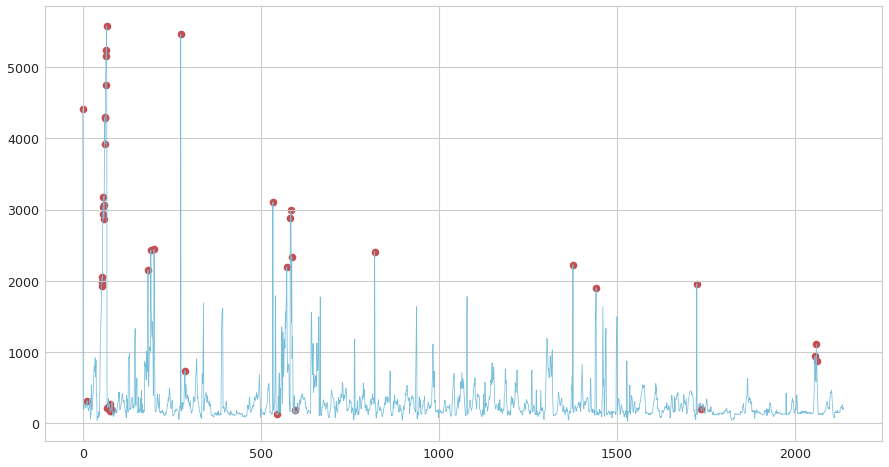

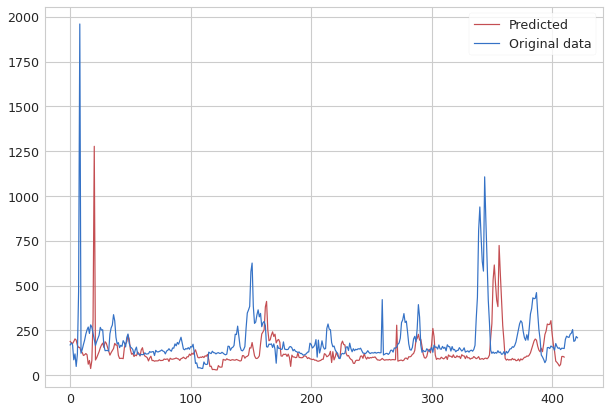

In [218]:
display_plots(X_train, X_val, y_train, y_val, model)

**Autoencoder with Dense layers.**

In [219]:
def AutoencoderDense(n_timesteps, n_features):
    i = Input(shape=(n_timesteps, n_features))
    
    x = Dense(dimensions, activation='relu')(i)
    x = Dropout(0.2)(x)

    x = Dense(int(dimensions/2), activation='relu')(x)
    x = Dropout(0.2)(x)

    x = Dense(int(dimensions/2), activation='relu')(x)
    x = Dense(dimensions, activation='relu')(x)
    output = Dense(n_features, activation='linear')(x)

    model = Model(inputs=i, outputs=output)
    opt = Adam(lr=0.01)
    model.compile(loss='mean_absolute_error', optimizer=opt)
    
    return model

In [220]:
model = AutoencoderDense(n_timesteps, n_features)
model.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 12, 1)]           0         
_________________________________________________________________
dense_20 (Dense)             (None, 12, 100)           200       
_________________________________________________________________
dropout_26 (Dropout)         (None, 12, 100)           0         
_________________________________________________________________
dense_21 (Dense)             (None, 12, 50)            5050      
_________________________________________________________________
dropout_27 (Dropout)         (None, 12, 50)            0         
_________________________________________________________________
dense_22 (Dense)             (None, 12, 50)            2550      
_________________________________________________________________
dense_23 (Dense)             (None, 12, 100)         

In [221]:
history = model.fit(X_train, X_train, batch_size=64, epochs=70, verbose=2, callbacks=None, validation_split=0.1, shuffle=False)

Epoch 1/70
25/25 - 0s - loss: 122.6638 - val_loss: 39.3473
Epoch 2/70
25/25 - 0s - loss: 31.1112 - val_loss: 72.4797
Epoch 3/70
25/25 - 0s - loss: 33.2851 - val_loss: 46.2537
Epoch 4/70
25/25 - 0s - loss: 26.4961 - val_loss: 70.5987
Epoch 5/70
25/25 - 0s - loss: 25.5675 - val_loss: 58.8179
Epoch 6/70
25/25 - 0s - loss: 22.0862 - val_loss: 75.2506
Epoch 7/70
25/25 - 0s - loss: 20.4653 - val_loss: 76.5940
Epoch 8/70
25/25 - 0s - loss: 20.1388 - val_loss: 72.8941
Epoch 9/70
25/25 - 0s - loss: 33.7741 - val_loss: 51.2302
Epoch 10/70
25/25 - 0s - loss: 20.9063 - val_loss: 72.6853
Epoch 11/70
25/25 - 0s - loss: 27.7961 - val_loss: 65.2976
Epoch 12/70
25/25 - 0s - loss: 23.6665 - val_loss: 73.9476
Epoch 13/70
25/25 - 0s - loss: 24.4822 - val_loss: 74.0645
Epoch 14/70
25/25 - 0s - loss: 22.0721 - val_loss: 77.2973
Epoch 15/70
25/25 - 0s - loss: 19.2286 - val_loss: 83.1810
Epoch 16/70
25/25 - 0s - loss: 17.8903 - val_loss: 80.8456
Epoch 17/70
25/25 - 0s - loss: 21.8544 - val_loss: 79.7982
Epoch

In [222]:
model.save('drive/My Drive/Colab Notebooks/autoencoderdense.h5')

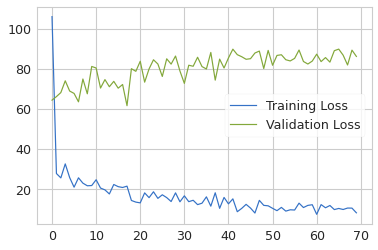

In [200]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

Training Result:  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

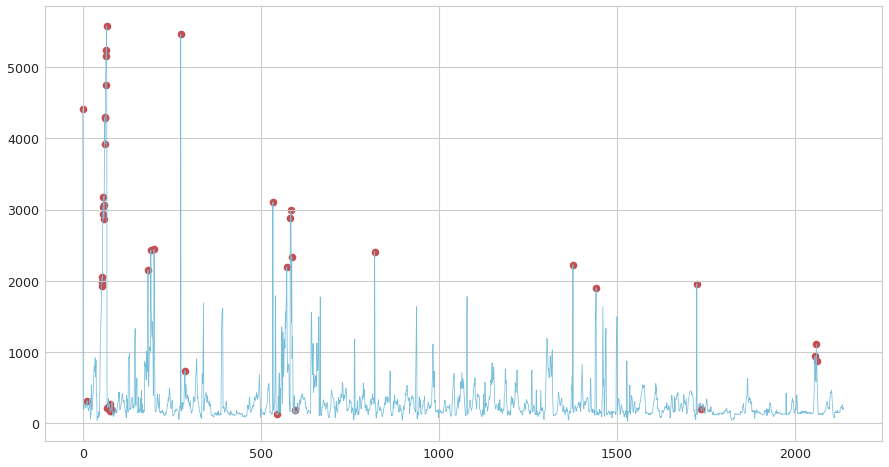

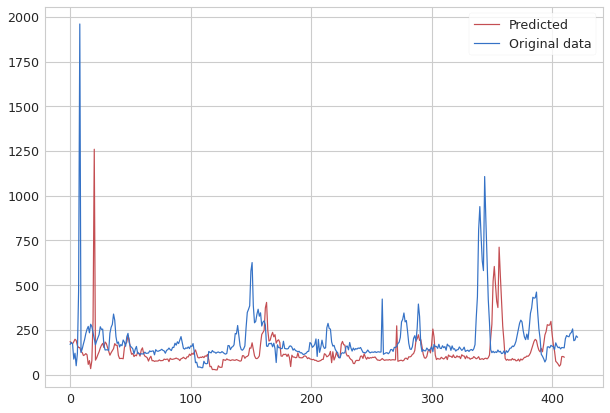

In [223]:
model = keras.models.load_model('drive/My Drive/Colab Notebooks/autoencoderdense.h5')
display_plots(X_train, X_val, y_train, y_val, model)

**Autoencoder with Conv1D layers.**

In [224]:
model = keras.Sequential(
    [
        layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding='same', strides=2, activation='relu'
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding='same', strides=2, activation='relu'
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding='same', strides=2, activation='relu'
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding='same', strides=2, activation='relu'
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding='same'),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

In [225]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 6, 32)             256       
_________________________________________________________________
dropout_28 (Dropout)         (None, 6, 32)             0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 3, 16)             3600      
_________________________________________________________________
conv1d_transpose_15 (Conv1DT (None, 6, 16)             1808      
_________________________________________________________________
dropout_29 (Dropout)         (None, 6, 16)             0         
_________________________________________________________________
conv1d_transpose_16 (Conv1DT (None, 12, 32)            3616      
_________________________________________________________________
conv1d_transpose_17 (Conv1DT (None, 12, 1)            

In [226]:
history = model.fit(X_train, X_train, batch_size=64, epochs=70, verbose=2, callbacks=None, validation_split=0.1, shuffle=False)

Epoch 1/70
25/25 - 0s - loss: 369776.8750 - val_loss: 22746.3809
Epoch 2/70
25/25 - 0s - loss: 168915.4219 - val_loss: 13205.4307
Epoch 3/70
25/25 - 0s - loss: 137712.3906 - val_loss: 8119.0894
Epoch 4/70
25/25 - 0s - loss: 123732.9375 - val_loss: 5648.8418
Epoch 5/70
25/25 - 0s - loss: 102124.9688 - val_loss: 4083.0806
Epoch 6/70
25/25 - 0s - loss: 87306.9844 - val_loss: 4471.3838
Epoch 7/70
25/25 - 0s - loss: 78448.3828 - val_loss: 4291.7310
Epoch 8/70
25/25 - 0s - loss: 68371.6328 - val_loss: 3131.2812
Epoch 9/70
25/25 - 0s - loss: 62749.3164 - val_loss: 3384.1570
Epoch 10/70
25/25 - 0s - loss: 70074.2969 - val_loss: 6847.3286
Epoch 11/70
25/25 - 0s - loss: 69787.3281 - val_loss: 5915.3574
Epoch 12/70
25/25 - 0s - loss: 55864.3789 - val_loss: 2892.5483
Epoch 13/70
25/25 - 0s - loss: 49801.3242 - val_loss: 1689.5304
Epoch 14/70
25/25 - 0s - loss: 43979.2812 - val_loss: 1089.3638
Epoch 15/70
25/25 - 0s - loss: 43412.3320 - val_loss: 814.1606
Epoch 16/70
25/25 - 0s - loss: 44678.2031 -

In [228]:
model.save('drive/My Drive/Colab Notebooks/autoencoderconv1d.h5')

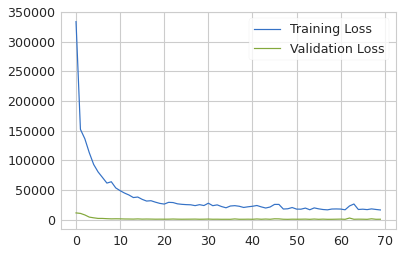

In [207]:
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.legend()

Training Result:  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

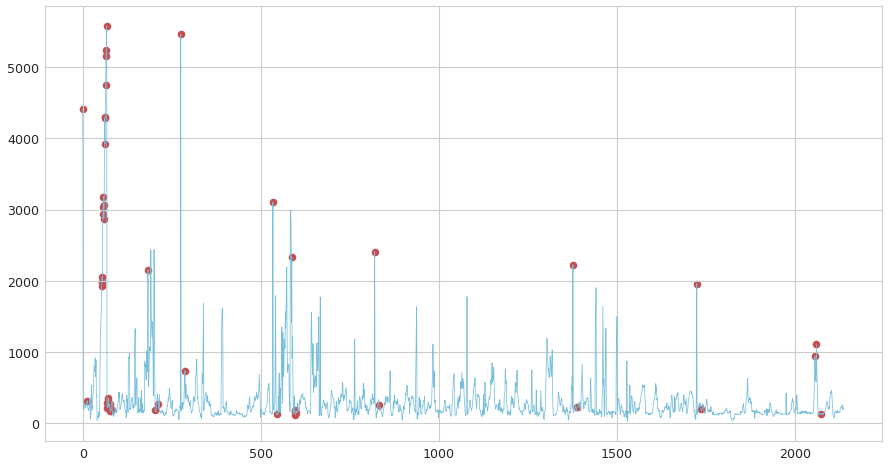

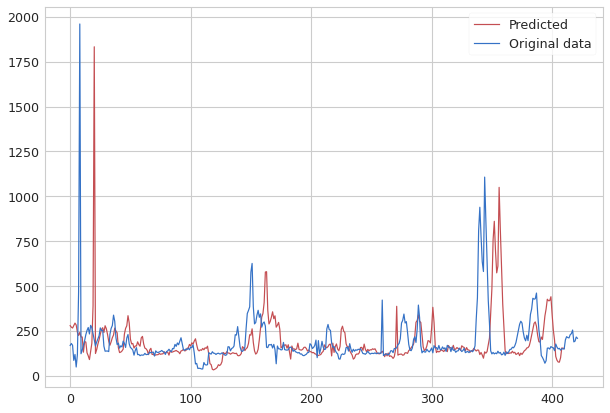

In [229]:
model = keras.models.load_model('drive/My Drive/Colab Notebooks/autoencoderconv1d.h5')
display_plots(X_train, X_val, y_train, y_val, model)

### References

##### *Datasets*
1. https://raw.githubusercontent.com/numenta/NAB/master/data/realTraffic/TravelTime_451.csv

##### *Code*
1. https://colab.research.google.com/github/jdwittenauer/ipython-notebooks/blob/master/notebooks/keras/AnomalyDetection.ipynb
2. https://towardsdatascience.com/lstm-autoencoder-for-anomaly-detection-e1f4f2ee7ccf

##### *Readings*
1. https://towardsdatascience.com/anomaly-detection-with-lstm-in-keras-8d8d7e50ab1b
2. https://arxiv.org/pdf/1906.11632.pdf
3. https://towardsdatascience.com/lstm-autoencoder-for-extreme-rare-event-classification-in-keras-ce209a224cfb
4. https://towardsdatascience.com/extreme-rare-event-classification-using-autoencoders-in-keras-a565b386f098
5. https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798

